# Employee Attrition Risk Assessment

---

This project aims to quantify employee attrition risks at an organisation using two survival analytic models: Cox Proportional Hazards regression (CoxPH) and Random Survival Forests (RSF). Recommended intervention strategies are also proposed.

### Data Source

Our dataset is sourced from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), made available under [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and [Database Content License](https://opendatacommons.org/licenses/dbcl/1.0/).

### Analysis Tool

We will be using R for our data analysis, including packages such as `survival`, `randomForestSRC` and `SurvMetrics` for modelling, as well as `rsample`, `DataExplorer`, `ggplot2`, `reshape2`, `corrplot`, `pec` and `plotly`.

## Importing Data

We set aside some test and validation data to measure our performance, and use the remaining data for the training stage starting from data processing. These data will be incorporated later for model testingg, cross-validation and final verification.

In [1]:
library(rsample)

# Importing data
rm(list = ls())
DATA <- read.csv("hr_data.csv")

# Saving some test and validation data
set.seed(100)
SPLIT <- initial_validation_split(DATA, c(0.75, 0.15))
TEST <- testing(SPLIT)
VALID <- validation(SPLIT)
hr <- training(SPLIT)
hr_full <- rbind(hr, VALID)

#set.seed(NULL)

---

## Pre-processing Data

Firstly, we will perform some exploratory data anslysis in order to find and fix patterns that may disrupt our models. Below is the code to show the dataset preview, data types and ranges, as well as missing values and outliers.

corrplot 0.92 loaded



,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6
6,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,⋯,2,80,2,17,3,2,7,7,7,7


'data.frame':	1102 obs. of  35 variables:
 $ Age                     : int  41 49 37 33 32 36 35 29 31 28 ...
 $ Attrition               : chr  "Yes" "No" "Yes" "No" ...
 $ BusinessTravel          : chr  "Travel_Rarely" "Travel_Frequently" "Travel_Rarely" "Travel_Frequently" ...
 $ DailyRate               : int  1102 279 1373 1392 1005 1299 809 153 670 103 ...
 $ Department              : chr  "Sales" "Research & Development" "Research & Development" "Research & Development" ...
 $ DistanceFromHome        : int  1 8 2 3 2 27 16 15 26 24 ...
 $ Education               : int  2 1 2 4 2 3 3 2 1 3 ...
 $ EducationField          : chr  "Life Sciences" "Life Sciences" "Other" "Life Sciences" ...
 $ EmployeeCount           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : int  1 2 4 5 8 13 14 15 16 19 ...
 $ EnvironmentSatisfaction : int  2 3 4 4 4 3 1 4 1 3 ...
 $ Gender                  : chr  "Female" "Male" "Male" "Female" ...
 $ HourlyRate              : int  94 61 92 56 79 94 

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1102        Length:1102        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 471.2  
 Median :36.00   Mode  :character   Mode  :character   Median : 806.5  
 Mean   :36.78                                         Mean   : 810.5  
 3rd Qu.:43.00                                         3rd Qu.:1160.8  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1102        Min.   : 1.000   Min.   :1.000   Length:1102       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.299   Mean   :2.914                     
                    3rd Qu.:15.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

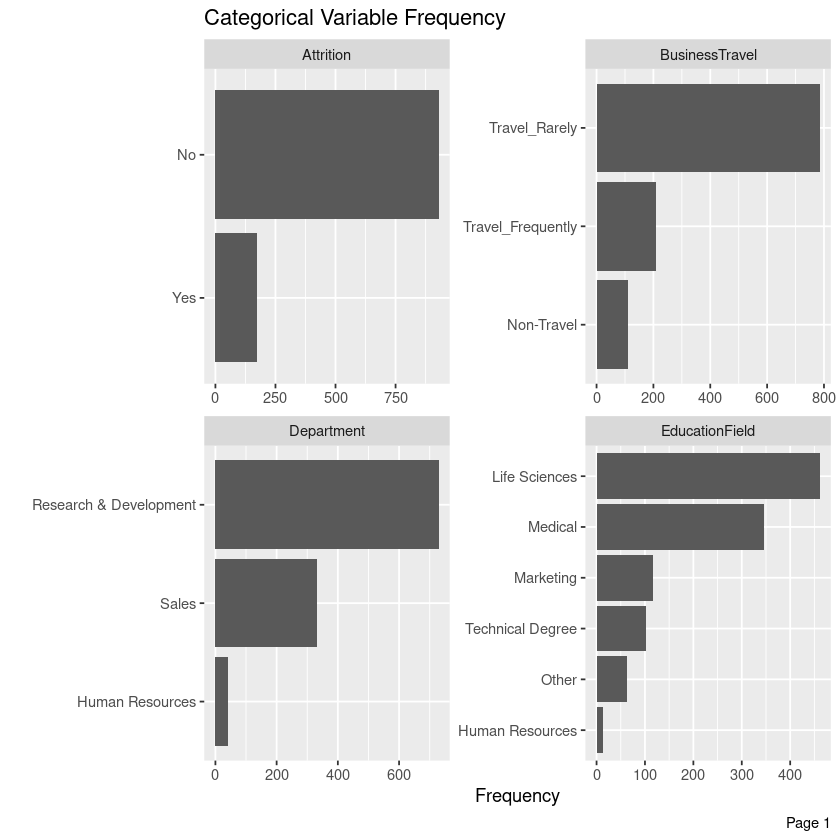

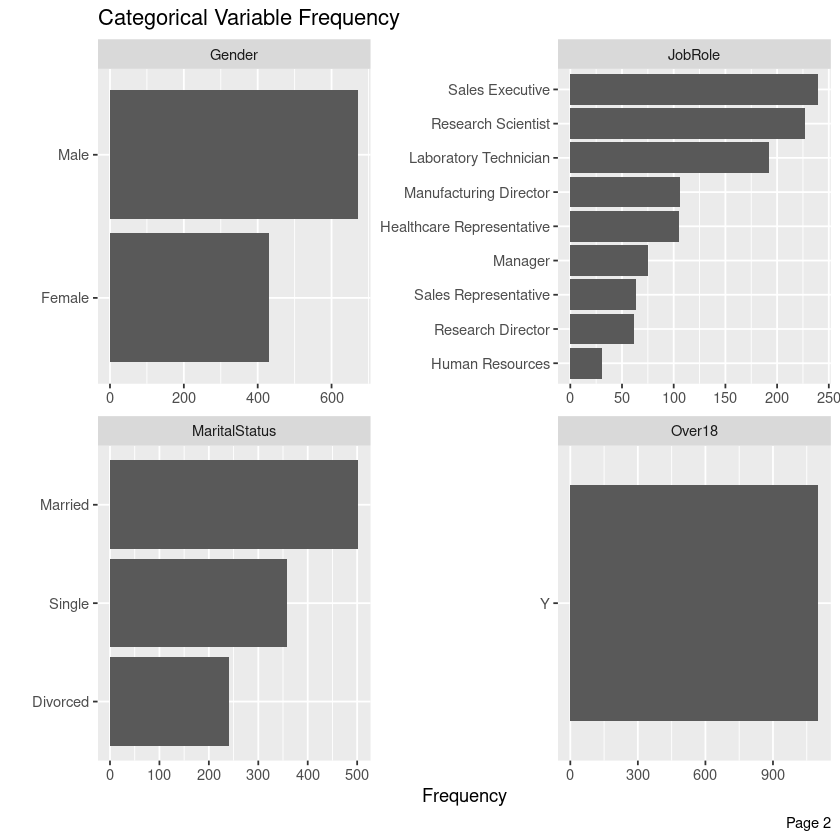

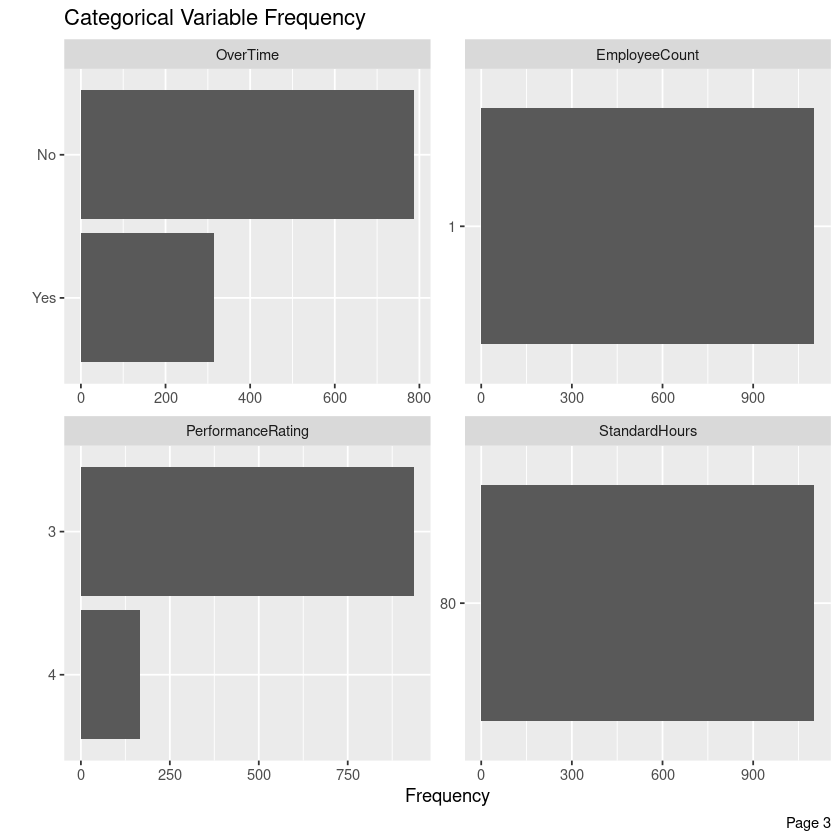

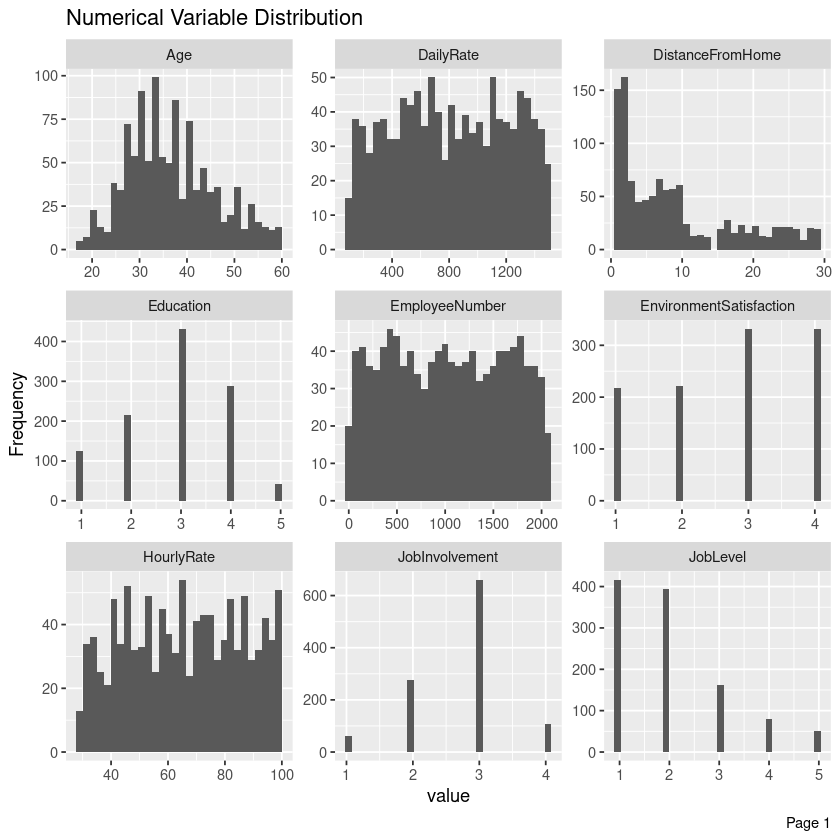

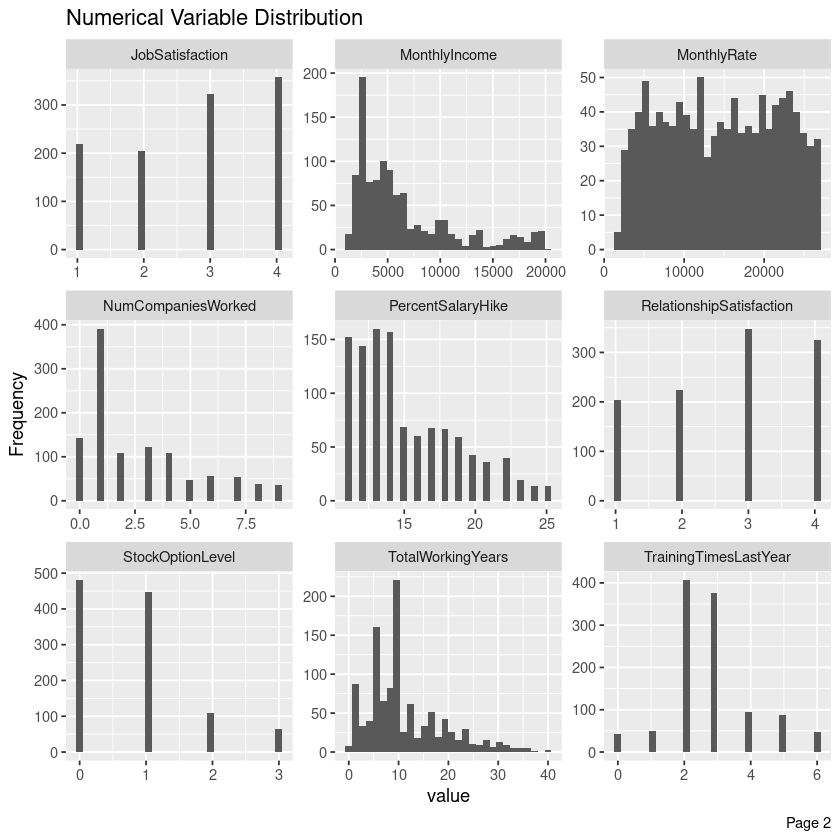

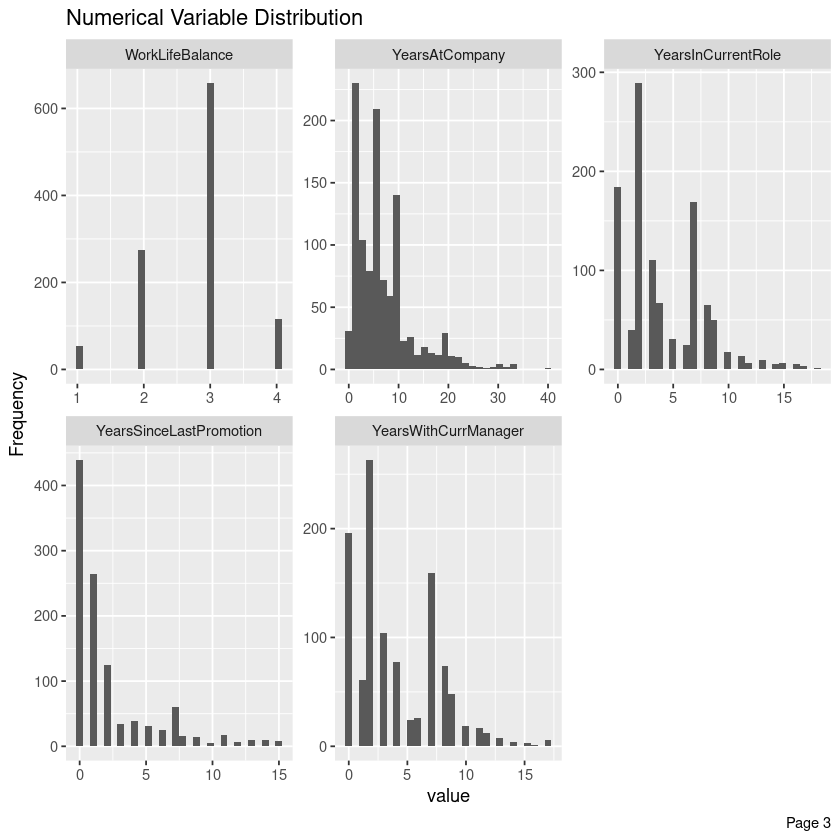

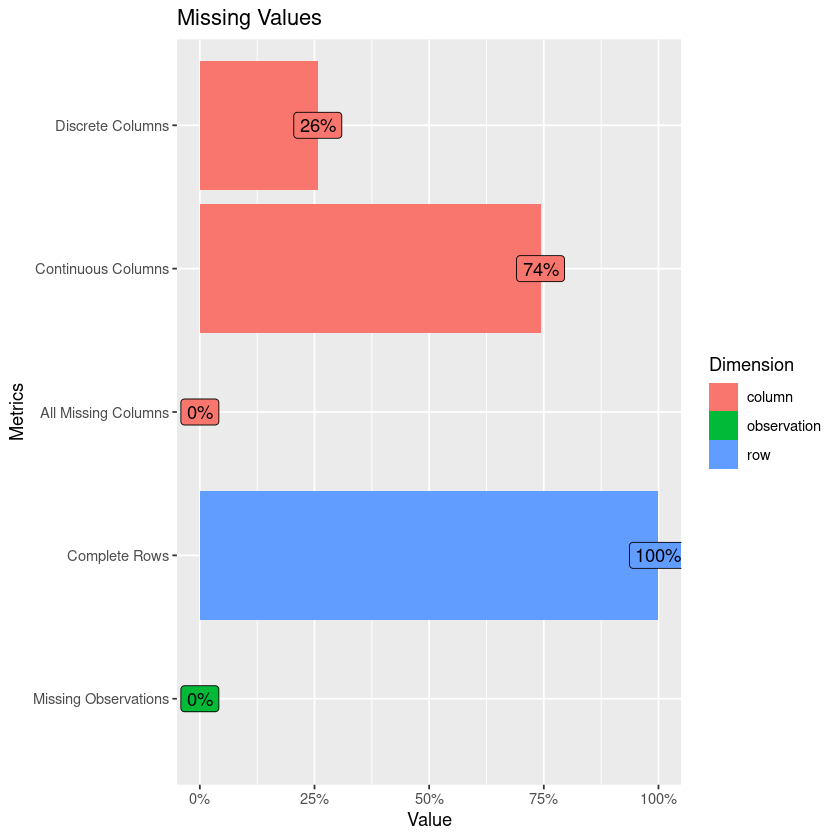

In [2]:
library(DataExplorer)
library(ggplot2)
library(reshape2)
library(corrplot)

# First few rows
head(hr)
# All columns' types and freq/dist (summary and plots)
str(hr)
summary(hr)
plot_bar(hr, title = "Categorical Variable Frequency", nrow = 2, ncol = 2)
plot_histogram(hr, title = "Numerical Variable Distribution", nrow = 3, ncol = 3)
# Info about missing values and outliers
plot_intro(hr, title = "Missing Values")

There are several noticable things from our exploratory output above:

1. `Attrition` and `YearsAtCompany` are our status and time variables of interest for survival analysis, while `EmployeeNumber` is the unique identification variable.

2. There are three single-valued variables (`EmployeeCount`, `Over18`, `StandardHours`) which cannot be considered for building a risk model. We will filter these variables along with `EmployeeNumber` via column name list to retain the original dataset.

3. All string variables are categorical, three of which (`Attrition`, `Over18`, `OverTime`) are semantically Boolean. For clarity, we can format their type as such.

4. All numerical features are integers, which for the purpose of modelling will be treated as continuous. This also includes rating/level variables such as `Education` and `JobInvolvement`.

5. There is no issues of missing values nor distinctive outliers. We will incorporate outlier removal on our model development later.


Some more nuanced observations:

1. The numerical variables seem to be distributed mostly like a right-skewed bell curve, with a few exceptions. The variables `DailyRate`, `MonthlyRate` and `HourlyRate` seem to be uniformly distributed which is very unusual. This might be accidentally introduced in our synthetic data creation. For this reason, we filter these columns from our consideration.

2. My separate exploration indicates some potential cross-column consistency issues on temporal columns (`Age`, `TotalWorkingYears`, `Years...`), such as whether a column should be larger/equal to another. But I was not able to verify this due to the lack of complete column descriptions. We are therefore skipping cleaning this aspect. I also make an assumption that the zero values in these columns (particularly `YearsAtCompany`) mean a round-down of "six months or less".

3. The `Attrition` rate is around $10-20\%$, which based on [some online information that I read](https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he?noredirect=1&lq=1) is not enough to pragmatically justify data-imbalance resampling. Adjusting the weights in model's metrics or incorporating external knowledge about minority class into the model could be an alternative for future attempts.

We now perform the data formatting and column filtering:

In [3]:
# Format data types
cat_cols <- c("BusinessTravel", "Department", "Gender", "EducationField", "JobRole", "MaritalStatus")
hr[cat_cols] <- lapply(hr[cat_cols], factor)
bool_cols <- c("Attrition", "Over18", "OverTime")
hr[bool_cols] <- lapply(hr[bool_cols], function (col) { col %in% c("Yes", "Y", TRUE) })

# Filter irrelevant columns
cols <- names(hr)
cols <- cols[cols != "EmployeeNumber"]
single_value_cols <- names(hr)[sapply(hr, function (col) { length(unique(col)) == 1 })]
cols <- cols[!(cols %in% single_value_cols)]
invalid_unif_cols <- c("DailyRate", "MonthlyRate", "HourlyRate")
cols <- cols[!(cols %in% invalid_unif_cols)]

head(hr[cols])

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,⋯,3,3,0,8,3,3,8,7,3,0
5,32,FALSE,Travel_Frequently,Research & Development,2,2,Life Sciences,4,Male,3,⋯,3,3,0,8,2,2,7,7,3,6
6,36,FALSE,Travel_Rarely,Research & Development,27,3,Medical,3,Male,3,⋯,3,2,2,17,3,2,7,7,7,7


From domain knowledge, we have time-dependent variables that are highly coupled to `YearsAtCompanies`", such as `Age`, `TotalWorkingYears`, `YearsInCurrentRole`, `YearsWithCurrManager` and `YearsSinceLastPromotion`(a separate check on our data shows around $70\%$ correlation). This is not insightful for our models, so we exclude these columns and substitute them with `NotWorkingYears` and `YearsAtOtherCompanies`.

In [4]:
# Removing temporal variables
coupled_cols <- c("Age", "TotalWorkingYears", "YearsWithCurrManager", "YearsInCurrentRole", "YearsSinceLastPromotion")
cols <- cols[!(cols %in% coupled_cols)]

# Adding a non-correlated variable
hr["NotWorkingYears"] <- hr["Age"] - hr["TotalWorkingYears"]
hr["YearsAtOtherCompanies"] <- hr["TotalWorkingYears"] - hr["YearsAtCompany"]
cols <- c(cols, "NotWorkingYears", "YearsAtOtherCompanies")

### Correlation Handling

Next, we also look at the column correlations which introduce multicollinearity that breaks the assumption of CoxPH model and is redundant to the performance of RSF model. We can improve this by performing PCA, but for now we will simply remove the extreme variables.

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,JobLevel,MonthlyIncome,0.9510894
2,DepartmentResearch & Development,DepartmentSales,-0.9199586


Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”


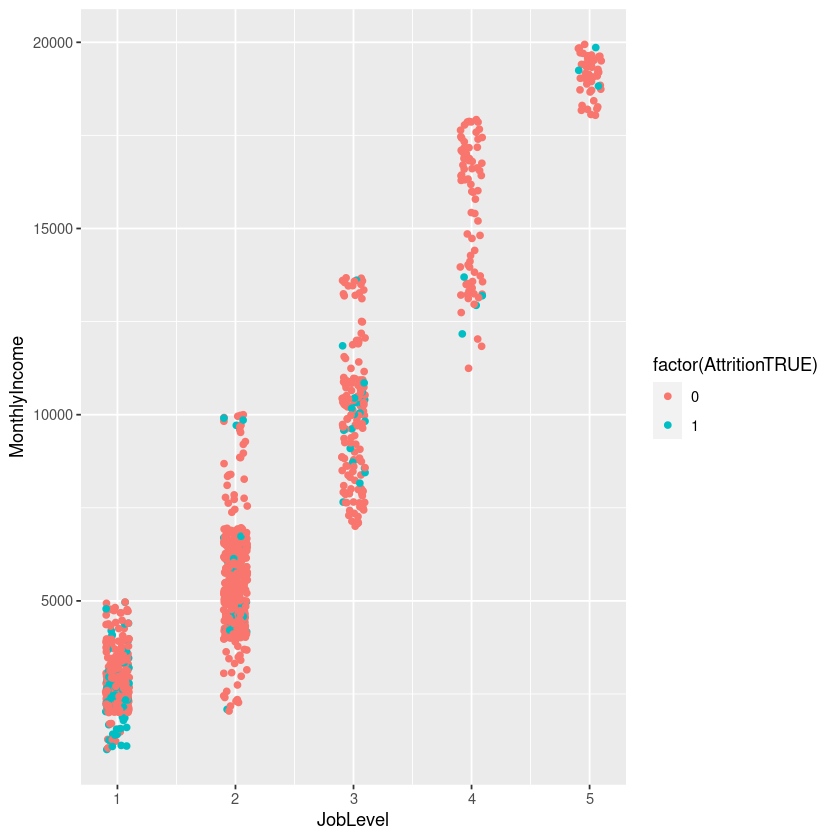

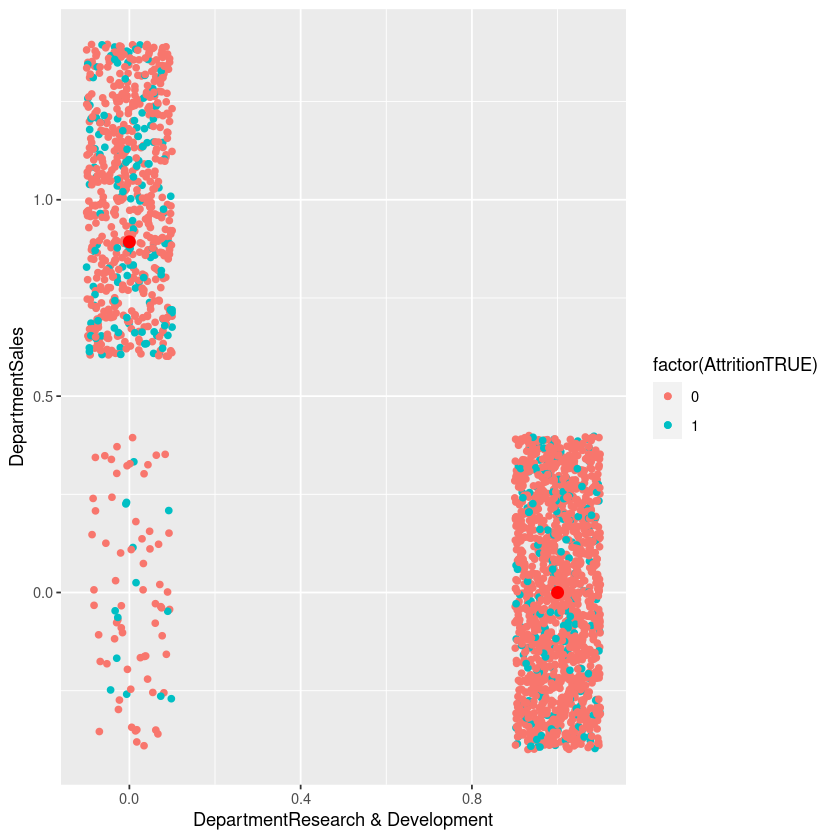

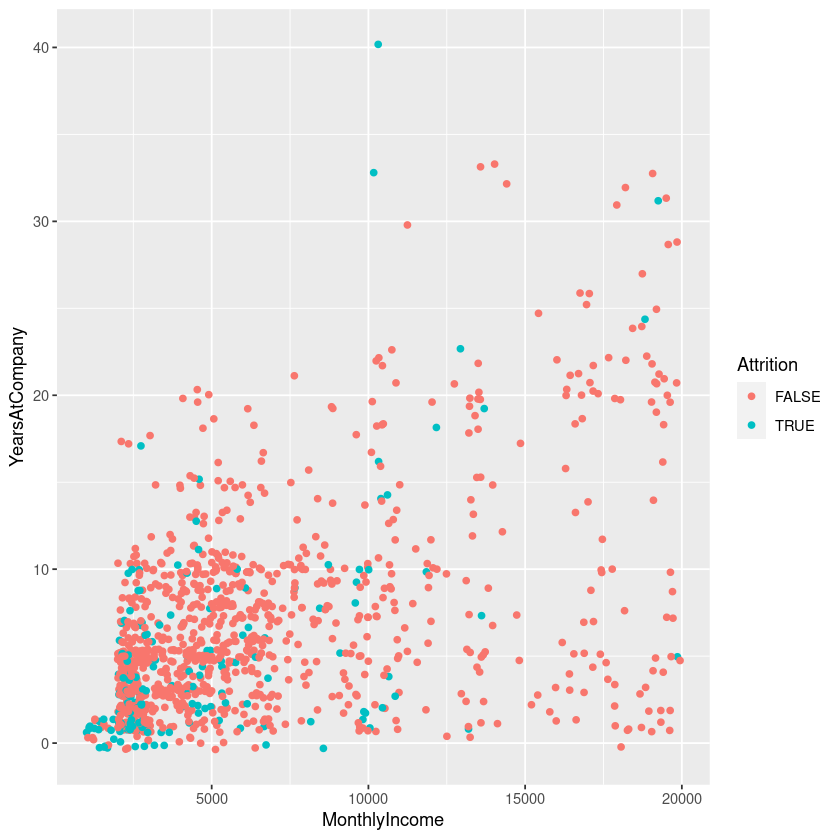

In [5]:
# Correlation functions: SOON

corr_table <- function (df, limit = 0){
  # Convert categories to dummies
  df2 <- model.matrix(~ 0+., df)

  # Dropping entries
  corr <- cor(df2)
  corr[lower.tri(corr, diag = TRUE)] <- NA
  corr[abs(corr) == 1] <- NA
  
  # Convert to long format, sorted
  res <- melt(corr)
  res <- na.omit(res)
  res <- res[abs(res$value) > limit,]
  res <- res[order(res$value, decreasing = TRUE),]
  rownames(res) <- 1:nrow(res)
  return(res)
}

corr_map <- function (df, limit = 0){
  # Detour to corr_table for simplified result=
  corr <- acast(corr_table(df, limit), Var1 ~ Var2)
  corrplot(corr, is.corr = FALSE, tl.col = "black", na.label = " ")
}

corr_graphs <- function (df, limit = 0){
  # Scatter plots of correlated variables
  df2 <- model.matrix(~ 0+., df)
  ct <- corr_table(df, limit)
    
  for (i in 1:nrow(ct)) {
    col1 <- as.character(ct[i, "Var1"])
    col2 <- as.character(ct[i, "Var2"])
    p <- ggplot(as.data.frame(df2), aes(x = .data[[col1]], y = .data[[col2]], color = factor(AttritionTRUE))) +
          geom_point(position = position_jitter(width = .1))
    if (!is.numeric(df[[col1]])) {
        p <- p + geom_jitter(position = position_jitter(width = .1)) +
                stat_summary(fun.y = "mean", geom = "point", color = "red", size = 3)
    }
    print(p)
  }
}

corr_table(hr[cols], limit = 0.9)
corr_graphs(hr[cols], limit = 0.9)
ggplot(hr[c("MonthlyIncome", "YearsAtCompany", "Attrition")],
       aes(x = MonthlyIncome, y = YearsAtCompany, color = Attrition)) +
       geom_point(position = position_jitter(width = .1))

The correlation between `MonthlyIncome` and `JobLevel` is so strong at above $90\%$, and there is a simple, non-coincidental explanation for this: higher job responsibilities should be rewarded higher. We exclude `JobLevel` and only include `MonthlyIncome` in our features. The negative correlation between `R&D` and `Sales` suggests a highly-binary behavior in `Department` variable, but since it has only three classes we will not merge them.

I also notice that `MonthlyIncome` under ~\$2,000 have a starkly different range of `YearsAtCompany`, almost as if it is artificially cut by someone. It also happens to have a high level of attrition. The only reason I can think of is because **these are employees on internship**, which have a very different work arrangement compared to full-fledged employees. We thus remove these rows from our training data.

In [6]:
# Removing highly-correlated variables
high_cor_cols <- c("JobLevel")
cols <- cols[!(cols %in% high_cor_cols)]

# Filtering internship data
hr <- hr[hr["MonthlyIncome"] >= 2000, ]

---

## Developing Survival Models

We utilise Cox Proportional Hazard and Random Survival Forest models, available from R's library `Survival` and `randomForestSRC`. These models offer distinct approaches: CoxPH model is commonly used in statistical analysis due to its interpretability and generalisation, allowing researchers to assess the contribution of variables and generate event's theoretical framework. Meanwhile, RSF is a powerful machine learning algorithm with embedded feature selection capabilities such as variable importance, which is able to incorporate non-linear relationships.

A [comparative research on high-dimensional data](https://www.nature.com/articles/s41598-020-77220-w) indicates that CoxPH with univariate concordance index's (C-index) feature selection and RSF with variable importance's feature selection perform quite well on empirical data. As a result, we are pairing both models with aforementioned feature selection methods.

We use concordance index (C-index) and Prediction Error Curve (PEC, i.e. integrated Brier score) to measure models' accuracy. The `YearsAtCompany` is set as survival time variable, and `Attrition` as status variable.

Below is the code for various functions used in our modelling:

In [7]:
library(survival)
suppressMessages(library(randomForestSRC))
library(SurvMetrics)
suppressMessages(library(pec))

# === Models

TIME <- "YearsAtCompany"
STATUS <- "Attrition"

coxph_model <- function (df) {
  formula <- as.formula(paste("Surv(", TIME, ", ", STATUS, ") ~ ."))
  model <- coxph(data = df, formula = formula, method = "breslow", x = TRUE)
  return(model)
}

rsf_model <- function (df) {
  formula <- as.formula(paste("Surv(", TIME, ", ", STATUS, ") ~ ."))
  model <- rfsrc(data = df, formula = formula, ntree = 100, block.size = 1)
  return(model)
}

model_f <- function (mode) { if (mode == "coxph") coxph_model else if (mode == "rsf") rsf_model else NULL }

In [8]:
# === Feature selection

# 1. Cox score

coxph_score <- function (df, model) { # ignore the model
  features <- names(df)[!(names(df) %in% c(TIME, STATUS))]
  scores <- sapply(features, function (col){
    summary(coxph_model(df[c(TIME, STATUS, col)]))$concordance[1]
  })
  names(scores) <- features
  return(scores)
}

coxph_details <- function (model) {
  return(summary(model)$coefficients[, c("exp(coef)", "coef", "se(coef)")])
}

# 2. RSF Importance

rsf_importance <- function (df, model) {
  return(predict(model, data = df, importance = TRUE)$importance)
}

feature_rank_f <- function (mode) { if (mode == "coxph") coxph_score else if (mode == "rsf") rsf_importance else NULL }


# ===

# SOON: 1D line
print_feature_rank <- function (df, mode) {
  if (mode == "coxph") {
    print("Univariate Cox score:")
  } else {
    print("Variable importance:")
  }
  res <- feature_rank_f(mode)(df, model_f(mode)(df))
  print(res[order(res, decreasing = TRUE)])
}

In [9]:
# === Accuracy metrics

# 1. C-index

c_index <- function (df, df2, mode) {
  # SurvMetrics variables incompatible with custom functions:
  #   model after df then tested after df2
  tmp <- list(time = TIME, status = STATUS)
  TIME <<- "time"
  STATUS <<- "status"
  rename_survmetrics <- function (df) {
    names(df)[names(df) == tmp$time] <- TIME
    names(df)[names(df) == tmp$status] <- STATUS
    return(df)
  }
  res <- SurvMetrics::Cindex(model_f(mode)(rename_survmetrics(df)), rename_survmetrics(df2), t_star = 10)
  TIME <<- tmp$time
  STATUS <<- tmp$status
  return(res)
}

c_index_pec <- function (df, model) {
  # From pec: pre-template model, tested after df
  formula <- as.formula(paste("Surv(", TIME, ", ", STATUS, ") ~ ."))
  c_table <- pec::cindex(model, data = df, formula = formula)
  if (unlist(c_table$Pairs) == 0) return(0) # In case of zero events
  return(unlist(c_table$AppCindex))
}


# 2. PEC


# ===

print_c_index <- function (df, df2, mode) {
  print("Concordance index:")
  print(c_index(df, df2, mode))
}

print_c_index_pec <- function (df, model) {
  print("Concordance index:")
  print(c_index_pec(df, model))
}

plot_pec <- function (df, model) { # split???
  formula <- as.formula(paste("Surv(", TIME, ", ", STATUS, ") ~ ."))
  pred_error <- pec(model, data = df, splitmethod = "cv10", formula = formula, cens.model = "marginal", reference = FALSE)
  plot(pred_error, xlim = c(0, 10), ylim = c(0, 0.25)) # 0.25 is the worst case scenario (random model)
  title("Prediction Error Curve")
}

In [10]:
# === Cross-validation

cross_val <- function (df, mode, feature_num = 1, k = 5) {
  random_index <- sample(1:nrow(df))
  performance_score1_vec <- numeric(k)
  for (fold in 1:k) {
    prev_end <- round((fold-1)/k * nrow(df))
    size <- round(fold * nrow(df)/k) - round((fold-1) * nrow(df)/k)
    idx <- random_index[(prev_end+1):(prev_end+size)]
    test <- df[idx, ]
    train <- df[-idx, ]
    
    # Preprocessing
    tt <- prepare(train, test, mode)
    train <- tt[[1]]
    test <- tt[[2]]
    
    # Initial model
    model1 <- model_f(mode)(train)
    feature_rank1 <- feature_rank_f(mode)(test, model1)
    
    # Correlated columns removal
    feature_redundancy <- corr_table(train, limit = 0.7)
    for (i in 1:nrow(feature_redundancy)) {
      # Retain higher rank, if any
      x <- feature_redundancy[i, "Var1"]
      y <- feature_redundancy[i, "Var2"]
      if (x %in% feature_rank1 && y %in% feature_rank1) {
        x_rank <- which(feature_rank1 == x)
        y_rank <- which(feature_rank1 == y)
        feature_rank1 <- feature_rank1[-max(x_rank, y_rank)]
      }
    }
    
    # Next model
    feature_rank2 <- names(feature_rank1)[1:min(feature_num, length(names(feature_rank1)))]
    #print("Choosing features ...")
    #print(feature_rank2)
    train2 <- train[c(TIME, STATUS, feature_rank2)]
    test2 <- test[c(TIME, STATUS, feature_rank2)]
    performance_score1 <- c_index(train2, test2, mode)
    # PEC variable soon
    
    performance_score1_vec[fold] <- performance_score1
  }

  print(paste0("Performance score via concordance index, for feature number = ", feature_num, ":"))
  # Box plot soon
  print(paste0("Mean: ", mean(performance_score1_vec)))
  print(performance_score1_vec)
  print(paste0("SE: ", sd(performance_score1_vec)))
}

In [11]:
# === Preprocessing

prepare <- function (df, df2 = NULL, mode = "") {
  # Helper function
  prepare1 <- function (df) {
    df[cat_cols] <- lapply(df[cat_cols], factor)
    df[bool_cols] <- lapply(df[bool_cols], function (col) { ifelse(col %in% c("Yes", "Y", TRUE), TRUE, FALSE) })
    df["NotWorkingYears"] <- df["Age"] - df["TotalWorkingYears"]
    df["YearsAtOtherCompanies"] <- df["TotalWorkingYears"] - df["YearsAtCompany"]
    df <- df[!(names(df) %in% c("EmployeeNumber", single_value_cols, invalid_unif_cols, coupled_cols, high_cor_cols))]
    return(df)
  }
  
  df <- prepare1(df)
  if (!is.null(df2)) {
    # Train and test dataset
    df2 <- prepare1(df2)
    # Outlier removal
    df <- df[-outlier_index(df, TIME, iqr_coef = 2), ]
    df <- df[df["MonthlyIncome"] >= 2000, ]
  }

  if (mode == "coxph") {
    # Assumption check
    cols <- colnames(df)
    focus_cols <- cols[!(cols %in% c("Department", "JobRole"))]
    pht <- proportional_hazard_table(coxph_model(df[focus_cols]))
    broken_ph_assumption_cols <- names(which(pht$table[, "p"] < 0.01))
    broken_ph_assumption_cols <- broken_ph_assumption_cols[!(broken_ph_assumption_cols == "GLOBAL")]
    for (col in broken_ph_assumption_cols) {
      inter_col <- paste0("Inter_TIME_", col)
      df[inter_col] <- df[TIME] * df[col]
      if (!is.null(df2)) {
        df2[inter_col] <- df2[TIME] * df2[col]
      }
    }
  } else if (mode == "rsf") {
    # None at the moment
  }
  return(if (is.null(df2)) df else list(df, df2))
}

outlier_index <- function (df, col, iqr_coef = 0) {
  vec <- df[[col]]
  qnt <- quantile(vec, probs = c(0.25, 0.75))
  iqr <- qnt[2] - qnt[1]
  min <- qnt[1] - iqr_coef * iqr
  max <- qnt[2] + iqr_coef * iqr
  return(which(vec < min | vec > max))
}

proportional_hazard_table <- function (model) {
  return(cox.zph(model))
}

### Outlier Removal

We remove outlier data with respect to survival time variable `YearsAtCompany`, to prevent too much variability in our training data. For model simplicity, we will remove points farther than twice the quartile difference from the quartiles.

In [12]:
hr0 <- hr[-outlier_index(hr, "YearsAtCompany", iqr_coef = 2), ]

## Cox Proportional Hazard: Feature Selection

There is another assumption of proportional hazard for CoxPH, which can be checked by performing statistical test on Schoenfeld residuals. The error message from `check_proportional_hazard()` suggests that `Department` and `JobRole` should be taken out from the test due to large fitted coefficients, although we will still include in the feature selection. The result does not seem to indicate any signficant violation (all $p > 0.01$)

In [13]:
# Check assumption
coxph_cols <- cols
hr0c <- hr0
VALID0c <- prepare(VALID, mode = "coxph") # The validation data also needs to be processed
focus_cols <- coxph_cols[!(coxph_cols %in% c("Department", "JobRole"))]
proportional_hazard_table(coxph_model(hr0[focus_cols]))

                            chisq df     p
BusinessTravel           1.72e-01  2 0.918
DistanceFromHome         2.94e-01  1 0.588
Education                6.23e-02  1 0.803
EducationField           4.79e+00  5 0.442
EnvironmentSatisfaction  3.95e-02  1 0.842
Gender                   8.47e-01  1 0.357
JobInvolvement           1.76e-03  1 0.967
JobSatisfaction          3.37e+00  1 0.066
MaritalStatus            9.65e-01  2 0.617
MonthlyIncome            3.66e+00  1 0.056
NumCompaniesWorked       2.56e+00  1 0.109
OverTime                 1.46e-02  1 0.904
PercentSalaryHike        5.20e-01  1 0.471
PerformanceRating        7.26e-01  1 0.394
RelationshipSatisfaction 1.08e+00  1 0.299
StockOptionLevel         8.31e-04  1 0.977
TrainingTimesLastYear    9.76e-03  1 0.921
WorkLifeBalance          6.63e-02  1 0.797
NotWorkingYears          3.50e+00  1 0.061
YearsAtOtherCompanies    1.01e-01  1 0.751
GLOBAL                   2.86e+01 26 0.329

Now we try our first iteration below. The concordance index of the initial model on validation set with all (feasible) columns selected is around $90\%$, with the PEC graph showing that our model has averagely around $7\%$ error in describing employee attrition within the span of 10 years.

[1] "Univariate Cox score:"
                 JobRole            MonthlyIncome                 OverTime 
               0.7069474                0.7061468                0.6616517 
        StockOptionLevel  EnvironmentSatisfaction            MaritalStatus 
               0.6127464                0.5928130                0.5878817 
         JobSatisfaction           JobInvolvement       NumCompaniesWorked 
               0.5862521                0.5769012                0.5646702 
          BusinessTravel               Department         DistanceFromHome 
               0.5588294                0.5527423                0.5459683 
   TrainingTimesLastYear           EducationField RelationshipSatisfaction 
               0.5456509                0.5449546                0.5303597 
               Education          WorkLifeBalance          NotWorkingYears 
               0.5277212                0.5216483                0.5174608 
       PercentSalaryHike                   Gender        Per

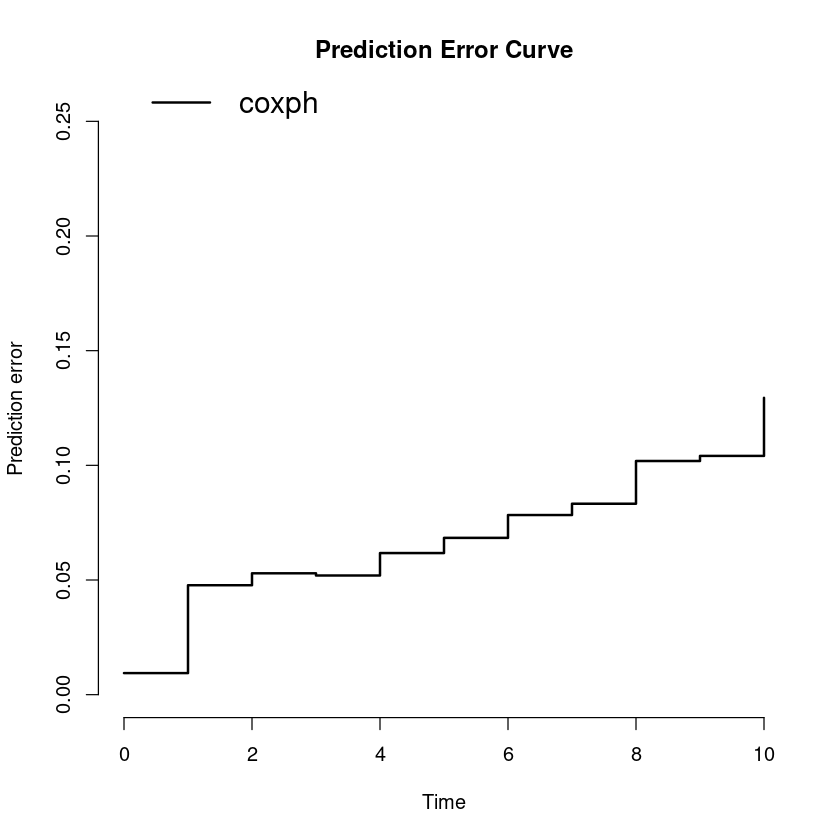

In [14]:
# First iteration
options(warn = -1) # Suppress warnings due to big coxph coefficients

hr1c <- hr0c[coxph_cols]
VALID1c <- VALID0c[coxph_cols]
print_feature_rank(hr1c, "coxph")

print_c_index(hr1c, VALID1c, "coxph")
plot_pec(VALID1c, coxph_model(hr1c))

options(warn = 0) # Reactivate warnings

We can see that (under this particular seed) `JobRole` and `MonthlyIncome` have much higher univariate concordance index compared to others. **The tuning of the number of features in CoxPH seems to suggest that picking top-3 variables will hit the balance between increased accuracy and simplicity (at around c-index $\approx$ 60\%).**

In [15]:
options(warn = -1) 

for (feature_num in 1:8) {
  cross_val(hr_full, "coxph", feature_num) 
}

options(warn = 0)

[1] "Performance score via concordance index, for feature number = 1:"
[1] "Mean: 0.575962"
[1] 0.651619 0.575036 0.555641 0.539887 0.557627
[1] "SE: 0.0440890009412778"
[1] "Performance score via concordance index, for feature number = 2:"
[1] "Mean: 0.587828"
[1] 0.592489 0.552725 0.519248 0.639084 0.635594
[1] "SE: 0.0521198863726697"
[1] "Performance score via concordance index, for feature number = 3:"
[1] "Mean: 0.6190094"
[1] 0.603845 0.701159 0.602523 0.549062 0.638458
[1] "SE: 0.0559490929354534"
[1] "Performance score via concordance index, for feature number = 4:"
[1] "Mean: 0.6144072"
[1] 0.658752 0.632518 0.626478 0.588202 0.566086
[1] "SE: 0.0369520549252677"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.6131546"
[1] 0.600024 0.636746 0.538862 0.643587 0.646554
[1] "SE: 0.045524740842755"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.6167764"
[1] 0.636417 0.610132 0.643473 0.620906 0.572954
[1] "S

## Random Survival Forest: Feature Selection

We develop Random Survival Forest model for our data now. The number of trees used in RSF is on the lower scale (100) for faster process. Note that there is no proportional hazard assumption here, so the initial feature set can be incorporated here.

The concordance index is at around $85\%$, with PEC error under $7.5\%$ across ten years.

In [21]:
# Incorporating info about internship data
rsf_cols <- cols
hr0r <- hr0
VALID0r <- prepare(VALID, mode = "rsf")

[1] "Variable importance:"
           MonthlyIncome                 OverTime                  JobRole 
             0.168365527              0.160470597              0.055303684 
         NotWorkingYears         StockOptionLevel  EnvironmentSatisfaction 
             0.045051032              0.043657320              0.038920499 
         WorkLifeBalance       NumCompaniesWorked    TrainingTimesLastYear 
             0.019839523              0.019747070              0.017661476 
              Department           JobInvolvement           EducationField 
             0.014960040              0.014363516              0.013257173 
        DistanceFromHome    YearsAtOtherCompanies          JobSatisfaction 
             0.012263016              0.010793823              0.006847734 
          BusinessTravel        PercentSalaryHike            MaritalStatus 
             0.003824920              0.003627783              0.002673939 
               Education        PerformanceRating Relationshi

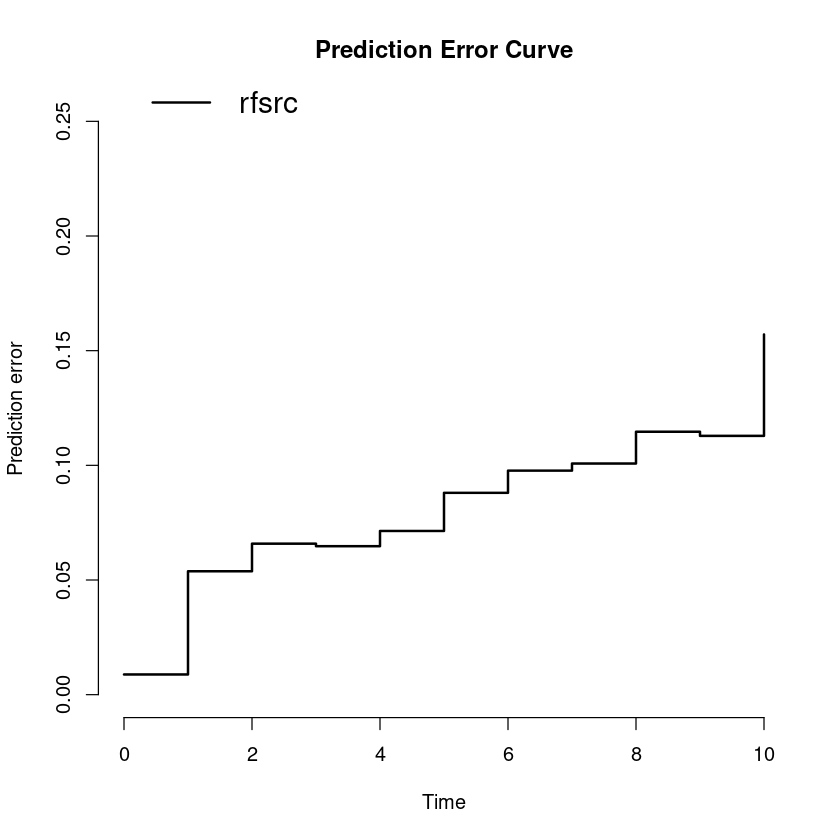

In [22]:
# First iteration
hr1r <- hr0r[rsf_cols]
VALID1r <- VALID0r[rsf_cols]
print_feature_rank(hr1r, "rsf")

print_c_index(hr1r, VALID1r, "rsf")
plot_pec(VALID1r, rsf_model(hr1r))

The prominently important features in RSF are `MonthlyIncome` and `OverTime`. Other features such as `EnvironmentSatisfaction` and `StockOptionLevel` also appear influential. The variable `JobRole` have several levels (i.e. 6), which might bias the RSF algorithm in favor of it.

**Our cross validation result below suggests that 9-10 top features in RSF might be a good spot with c-index $\approx$ 75\%**.

In [23]:
for (feature_num in 1:10) {
  cross_val(hr_full, "rsf", feature_num) 
}

[1] "Performance score via concordance index, for feature number = 1:"
[1] "Mean: 0.573929"
[1] 0.572225 0.614204 0.614911 0.542378 0.525927
[1] "SE: 0.0406329951209605"
[1] "Performance score via concordance index, for feature number = 2:"
[1] "Mean: 0.5900972"
[1] 0.609573 0.615128 0.500065 0.649700 0.576020
[1] "SE: 0.0567060536865334"
[1] "Performance score via concordance index, for feature number = 3:"
[1] "Mean: 0.5641736"
[1] 0.613521 0.652629 0.542980 0.533463 0.478275
[1] "SE: 0.0689753629769355"
[1] "Performance score via concordance index, for feature number = 4:"
[1] "Mean: 0.5443978"
[1] 0.539406 0.504371 0.635845 0.484686 0.557681
[1] "SE: 0.0585909456204625"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.5575434"
[1] 0.581439 0.536369 0.542055 0.575216 0.552638
[1] "SE: 0.0199726637507369"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.6119936"
[1] 0.582415 0.632486 0.683137 0.605472 0.556458
[1] 

## Completing Final Models

Our final model is formed by two methods of CoxPH and RSF, each with optimal features of four and seven respectively. The features are manually picked based on our initial training data's feature ranking.

In [26]:
options(warn = -1) 

coxph_feature_num <- 3
rsf_feature_num <- 9
coxph_cols <- c("Attrition", "YearsAtCompany", "MonthlyIncome", "JobRole", "OverTime")
rsf_cols <- c("Attrition", "YearsAtCompany", "OverTime", "MonthlyIncome", "StockOptionLevel", "TrainingTimesLastYear",
              "EnvironmentSatisfaction", "JobRole", "NumCompaniesWorked", "NotWorkingYears", "WorkLifeBalance")

hr_full_c <- prepare(hr_full, mode = "coxph")[coxph_cols]
hr_full_r <- prepare(hr_full, mode = "rsf")[rsf_cols]
coxph_final_model <- coxph_model(hr_full_c)
rsf_final_model <- rsf_model(hr_full_r)

options(warn = 0)

## Interlude: Feature Category Impact

Since `JobRole` appears influential in both CoxPH and RSF models, it is worth checking out which categories have large impact. An easy way to check this is via the full CoxPH summary table, provided in `coxph_details()`. It seems being Sales Reps in particular multiply the hazard ratio by a whopping $8.5$ times, while Managers and Directors have a decreased hazard ratio.

In [27]:
coxph_details(coxph_final_model)

,exp(coef),coef,se(coef)
MonthlyIncome,0.9998193,-0.0001807156,0.0000428842
JobRoleHuman Resources,3.8891567,1.3581923538,0.5236144477
JobRoleLaboratory Technician,4.2054376,1.4363783536,0.4434541747
JobRoleManager,1.3553443,0.3040555538,0.7318865374
JobRoleManufacturing Director,1.5003892,0.4057245437,0.5076004387
JobRoleResearch Director,1.1608668,0.1491669470,0.8678107572
JobRoleResearch Scientist,2.4648243,0.9021205446,0.4522002690
JobRoleSales Executive,3.4601145,1.2413016800,0.4137384785
JobRoleSales Representative,8.6334187,2.1556405684,0.4703329368
OverTimeTRUE,3.2336229,1.1736031427,0.1385589198


---

## Quantifying Employee Attrition Risk

We produce the estimated cumulative hazard function (CHF) of attrition for each of our employee $i$ for Random Survival Forest model, and hazard ratio relative to the exponent of mean for Cox Proportional Hazard model.

In particular, the rank for employee risk based on RSF is determined by the long-term CHF for the next five years, since it is commonly the period where companies may conduct review of their structural performance.

In [28]:
# Appending predictions
years = 5
rsf_risk <- predict(rsf_final_model, hr_full_r[rsf_cols])$chf[, 1 + (0:years)] # matrix
rsf_survival_probs <- predict(rsf_final_model, hr_full_r[rsf_cols])$survival[, 1 + (0:years)]
hr_full_r["Hazard_RSF_in_1yr"] <- rsf_risk[, 2]
hr_full_c["HazardRatio_CoxPH"] <- predict(coxph_final_model, hr_full_c[coxph_cols], type = "risk")

preview_rsf_cols <- c("EmployeeNumber", rsf_cols, "Hazard_RSF_in_1yr")
preview_coxph_cols <- c("EmployeeNumber", coxph_cols, "HazardRatio_CoxPH")
hr_full_r["EmployeeNumber"] <- hr_full["EmployeeNumber"]
hr_full_c["EmployeeNumber"] <- hr_full["EmployeeNumber"]

# Table sorted by hazards
cutoff = 20
sorted <- function (df, key_col) {
  df <- df[df["Attrition"] == FALSE, ]
  return(df[order(df[, key_col], decreasing = TRUE), ][1:cutoff, ])
}
hr_sorted_rsf <- sorted(hr_full_r, "Hazard_RSF_in_1yr")
hr_sorted_coxph <- sorted(hr_full_c, "HazardRatio_CoxPH")
head(hr_sorted_rsf[, preview_rsf_cols])
head(hr_sorted_coxph[, preview_coxph_cols])

,EmployeeNumber,Attrition,YearsAtCompany,OverTime,MonthlyIncome,StockOptionLevel,TrainingTimesLastYear,EnvironmentSatisfaction,JobRole,NumCompaniesWorked,NotWorkingYears,WorkLifeBalance,Hazard_RSF_in_1yr
,<int>,<lgl>,<int>,<lgl>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<dbl>
224,411,FALSE,0,FALSE,1200,0,2,4,Sales Representative,1,18,3,0.6063295
546,1012,FALSE,0,FALSE,1051,0,2,2,Research Scientist,1,18,3,0.5914430
18,30,FALSE,0,FALSE,1232,0,6,3,Research Scientist,1,21,3,0.5655645
112,201,FALSE,1,FALSE,1483,0,3,2,Laboratory Technician,1,18,3,0.5415002
1245,1368,FALSE,0,FALSE,1611,0,5,4,Laboratory Technician,1,18,4,0.4439773
1297,1839,FALSE,0,FALSE,1514,0,4,2,Research Scientist,1,18,1,0.4434455


,EmployeeNumber,Attrition,YearsAtCompany,MonthlyIncome,JobRole,OverTime,HazardRatio_CoxPH
,<int>,<lgl>,<int>,<int>,<fct>,<lgl>,<dbl>
114,205,FALSE,7,2306,Sales Representative,TRUE,59.51821
1260,1541,FALSE,11,2308,Sales Representative,TRUE,59.49671
1080,2021,FALSE,2,2380,Sales Representative,TRUE,58.72758
377,666,FALSE,8,2579,Sales Representative,TRUE,56.65312
829,1556,FALSE,3,2644,Sales Representative,TRUE,55.99153
501,925,FALSE,3,3294,Sales Representative,TRUE,49.78608


## Visualising with Plotly

We also use Plotly library to derive an interactive visualisation of the list of top $20$ employees at risk, where user can group employees according to several factors describing trends of attrition risks based on various factors.

In [29]:
# Plotly implementation
suppressMessages(library(plotly))

fig <- plot_ly()

# --- Adding traces
# RSF
employee_row_num_wrt_ <- match(1:length(hr_sorted_rsf), hr_sorted_rsf)
for (rank in 1:cutoff) {
  employee_row_num <- as.numeric(rownames(hr_sorted_rsf)[rank])
  employee_row <- hr_sorted_rsf[rank, ]
  x <- 0:years
  y <- rsf_risk[employee_row_num, ]
  fig <- fig %>% add_trace(x = x,
                           y = y,
                           name = employee_row["EmployeeNumber"],
                           type = "scatter", mode = "lines+markers", # Every time you put type, it assign DOMNum = 0
                           marker = list(size = 6),
                           line = list(shape = "spline", width = 2),
                           hovertemplate = paste0("<b>", rank, ". Employee ", employee_row["EmployeeNumber"], "</b>",
                                                 "<br>Year: %{x}",
                                                 "<br>Cumulative risk: %{y:.2f}"),
                           hoverlabel = list(font_size = 16),
                           legendrank = rank,
                           legendgroup = employee_row["EmployeeNumber"],
                           showlegend = TRUE)
}

# CoxPH
fig <- fig %>% add_trace(data = hr_sorted_coxph,
                         x = 1:cutoff,
                         y = ~HazardRatio_CoxPH,
                         type = "bar",
                         marker = list(color = 1:cutoff, colorscale = list(c(0, "#64a1f4"), c(1, "#bfe6b5"))), # blue-green
                         hovertemplate = paste0("<b>%{x}. Employee ", hr_sorted_coxph$EmployeeNumber, "</b>",
                                                "<br>Risk ratio: %{y:.2f}"),
                         hoverlabel = list(bgcolor = "white", font_size = 16),
                         showlegend = FALSE,
                         visible = FALSE)


# --- Decorators
# Including the baseline
avg_cum_hazard <- -log(1-mean(hr[, "Attrition"]))
baseline <- list(
  type = "line", x0 = 0, x1 = 5, y0 = avg_cum_hazard, y1 = avg_cum_hazard,
  line = list(dash = "dash", width = 4, color = "#82A0D8")
)
fig <- fig %>% add_text(
  x = 0.3, y = 0.22,
  text = "Average hazard", textfont = list(family = "sans serif", size = 12),
  showlegend = FALSE
)

# Helper functions to group CHF based on variables
library(RColorBrewer)
unique_index <- function(x) {
  unique_vals <- unique(x)
  first_occur <- integer(length(unique_vals))
  for (i in 1:length(unique_vals)) {
    first_occur[i] <- which(x == unique_vals[i])[1]
  }
  return(first_occur)
}
create_buttons <- function(vars) {
  lapply(vars, function(var) {
    color_num <- 8
    color_palletes <- brewer.pal(color_num, "Set2")
    var_factors <- as.numeric(factor(hr_sorted_rsf[[var]]))
    button <- list(
      method = "restyle",
      label = var,
      args = list(list( # Please read Plotly.js for detailed documentation (not R/Python)
        line.color = color_palletes[var_factors %% color_num + 1],
        marker.color = color_palletes[var_factors %% color_num + 1],
        legendrank = if(var == "EmployeeNumber") 1:cutoff else var_factors,
        legendgroup = hr_sorted_rsf[[var]],
        showlegend = 1:cutoff %in% unique_index(var_factors),
        name = as.character(hr_sorted_rsf[[var]])
      ), 1:cutoff - 1)
    )
    return(button)
  })
}


# --- Setting layout
rsf_layout = list( 
  title = "Top 20 High-Risk Employees, according to RSF's Cumulative Risk in Five Years",
  shapes = list(baseline),
  xaxis = list(title = "Year", range = c(0, 5), zerolinecolor = 'white'),
  yaxis = list(title = "Accummulated Risk over Time", range = c(0, 1.2), zerolinecolor = 'white'),
  `annotations[1].visible` = TRUE,
  `updatemenus[1].visible` = TRUE
)
coxph_layout = list(
  title = "Top 20 High-Risk Employees, according to CoxPH's Risk Ratio",
  shapes = list(),
  xaxis = list(title = "Employee ID", tickmode = "array", tickvals = 1:cutoff,
               ticktext = hr_sorted_coxph["EmployeeNumber"], zerolinecolor = 'white'),
  yaxis = list(title = "Risk Ratio", zerolinecolor = 'white'),
  `annotations[1].visible` = FALSE,
  `updatemenus[1].visible` = FALSE
)
fig <- fig %>% layout( # do.call soon
  title = "Top 20 High-Risk Employees, according to RSF's Cumulative Risk in Five Years",
  shapes = list(baseline),
  xaxis = list(title = "Year", range = c(0, 5), zerolinecolor = 'white'),
  yaxis = list(title = "Accummulated Risk over Time", range = c(0, 1.2), zerolinecolor = 'white'),
  margin = list(l = 50, t = 50, b = 50, r = 50),
  plot_bgcolor = '#e5ecf6',
  annotations = list(
    list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 1, xref = "paper", yref = "paper", 
      text = "Method", align = "left", showarrow = FALSE
    ), list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.8, xref = "paper", yref = "paper", 
      text = "Based on", align = "left", showarrow = FALSE
    )
  ),
  updatemenus = list(
    list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.95, xref = "paper", yref = "paper",
      showactive = TRUE,
      buttons = list(
        list(
          label = "Random Survival Forest",
          method = "update",
          args = list(list(visible = c(rep(TRUE, cutoff), FALSE, TRUE)), rsf_layout, 1:(cutoff+2) - 1)
        ),
        list(
          label = "Cox Proportional Hazard",
          method = "update",
          args = list(list(visible = c(rep(FALSE, cutoff), TRUE, FALSE)), coxph_layout, 1:(cutoff+2) - 1)
        )
      )
    ), list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.75, xref = "paper", yref = "paper",
      showactive = TRUE,
      buttons = create_buttons(c("EmployeeNumber", "EnvironmentSatisfaction", "JobRole", "MonthlyIncome", "NumCompaniesWorked",
                                 "NotWorkingYears", "OverTime", "StockOptionLevel", "TrainingTimesLastYear", "WorkLifeBalance"))
    )
  )
)

# Build the HTML widget, only for the case of nbviewer
# Otherwise, simply the line `fig` will suffice
htmlwidgets::saveWidget(as_widget(fig), "plot.html")
IRdisplay::display_html("<iframe seamless src='plot.html' width=1000, height=600></iframe>")
# fig

---

## Recommended Strategies

### Stay Interviews with High-Risk Employees

Conduct stay interviews with employees to understand their perspectives and needs. Use risk scores to prioritize who to interview, but recognize the limitations of only using a few variables to predict individuals and gain individual perspectives and concerns.

### Career Welfare Support

Survey employees on factors like overtime expectations, work-life balance satisfaction, company culture/environment to gain a holistic understanding beyond data variables. Overtime in particular seems correlated and needs some proper management.

### Targetted Retention Program for Sales Reps

Develop retention programs tailored specifically for sales representations, who showed higher attrition risk compared to other positions. Pilot mentorship matching, expanded training support, career path guidance, or revised compensation incentives focused on these groups. Assess needs periodically and refine programs over time based on attrition trends and feedback.

### Financial Benefits & Compensation

Ensure that compensation and benefits packages are competitive and aligned with industry standards. Consider revising the stock option plans or other incentives to increase employee motivation and loyalty.

---

## Epilogue: Accuracy Check on Data

In [30]:
TEST_c <- prepare(hr_full, TEST, mode = "coxph")[[2]][coxph_cols]
TEST_r <- prepare(hr_full, TEST, mode = "rsf")[[2]][rsf_cols]

c_index(TEST_c, hr_full_c, "coxph")
c_index(TEST_r, hr_full_r, "rsf")

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  6 ; coefficient may be infinite. ”


C index 
0.792213

C index 
0.773011

In [ ]:
# Further improvement:
# - Better pipelining: tidyverse, recipes etc
# - Hypergrid tuning
# - Brier scores etc from SurvMetrics